In [2]:
!pip install --user easyocr
!pip install --user torch torchvision
!pip install --user opencv-python-headless



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import re
import easyocr

%matplotlib inline

In [4]:
# Initialize EasyOCR reader (English only, CPU)
reader = easyocr.Reader(['en'], gpu=False)

INVOICE_DIR = "data/Invoices"
IMG_EXTS = (".jpg", ".jpeg", ".png")

print("Invoice directory:", INVOICE_DIR)
print("Image extensions:", IMG_EXTS)

Using CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteInvoice directory: data/Invoices
Image extensions: ('.jpg', '.jpeg', '.png')


In [7]:
invoice_files = sorted([
    f for f in os.listdir(INVOICE_DIR)
    if f.lower().endswith(IMG_EXTS)
])

print("Total invoices found:", len(invoice_files))
print("First 5:", invoice_files[:5])

INVOICE_FILE = invoice_files[0]
INVOICE_PATH = os.path.join(INVOICE_DIR, INVOICE_FILE)

print("Processing:", INVOICE_PATH)

Total invoices found: 499
First 5: ['batch1-0001.jpg', 'batch1-0002.jpg', 'batch1-0003.jpg', 'batch1-0004.jpg', 'batch1-0005.jpg']
Processing: data/Invoices\batch1-0001.jpg


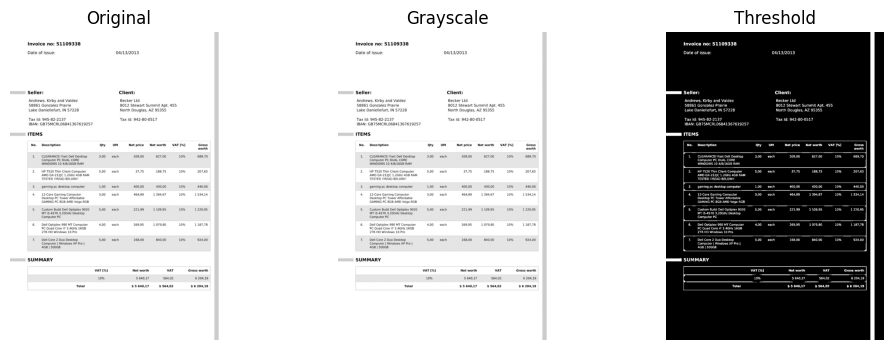

In [8]:
def load_invoice(path, max_width=1200):
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Could not load image: {path}")
    h, w = img.shape[:2]
    if w > max_width:
        scale = max_width / w
        img = cv2.resize(img, (int(w * scale), int(h * scale)))
    return img

invoice_color = load_invoice(INVOICE_PATH)
invoice_gray  = cv2.cvtColor(invoice_color, cv2.COLOR_BGR2GRAY)

thresh = cv2.adaptiveThreshold(
    invoice_gray, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY_INV,
    31, 10
)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(invoice_color, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(invoice_gray, cmap="gray"); plt.title("Grayscale"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(thresh, cmap="gray"); plt.title("Threshold"); plt.axis("off")
plt.show()

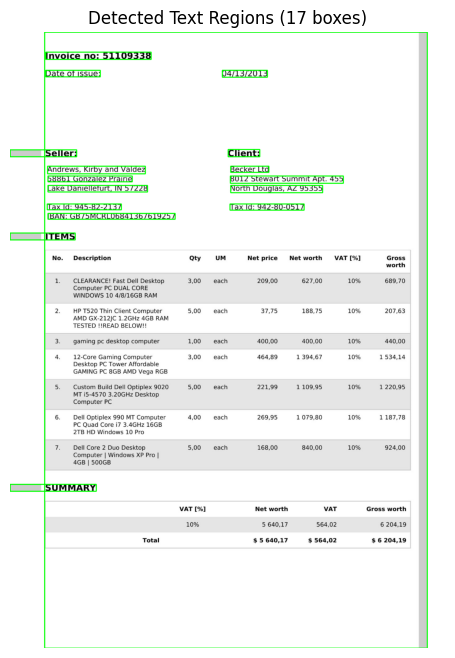

In [9]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 5))
morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

boxes = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    area = w * h
    if area < 500 or h < 15:
        continue
    boxes.append((x, y, w, h))

vis = invoice_color.copy()
for (x,y,w,h) in boxes:
    cv2.rectangle(vis, (x,y), (x+w,y+h), (0,255,0), 2)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Text Regions ({len(boxes)} boxes)")
plt.axis("off")
plt.show()

In [10]:
def ocr_box(gray, box):
    x, y, w, h = box
    roi = gray[y:y+h, x:x+w]
    result = reader.readtext(roi, detail=0)
    return " ".join(result).strip()

ocr_results = []
for b in boxes:
    text = ocr_box(invoice_gray, b)
    if text:
        ocr_results.append({"box": b, "text": text})

print("OCR regions with non-empty text:", len(ocr_results))
for r in ocr_results[:10]:
    print(r["box"], "->", repr(r["text"]))

c:\Users\pranav.vetkar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


OCR regions with non-empty text: 17
(0, 1245, 237, 19) -> 'SUMMARY'
(0, 553, 179, 19) -> 'TEMS'
(104, 499, 350, 16) -> 'IBAN: GBZSMCRL06841367619257'
(605, 473, 204, 17) -> 'Tax Id: 942-80-0517'
(102, 473, 204, 16) -> 'Tax Id: 945-82-2137'
(607, 422, 253, 20) -> 'North Douglas, AZ 95355'
(104, 422, 274, 18) -> 'Lake Daniellefurt, IN 57228'
(606, 396, 311, 20) -> '8012 Stewart Summit Apt: 455'
(104, 396, 232, 16) -> '58861 Gonzalez Prairie'
(607, 369, 105, 17) -> 'Becker Ltd'


In [11]:
DATE_REGEXES = [
    r"\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b",
    r"\b\d{4}[/-]\d{1,2}[/-]\d{1,2}\b",
]

NUMBER_REGEX = r"[-+]?\d{1,3}(?:,\d{3})*(?:\.\d+)?"

AMOUNT_WORDS = ["total", "amount", "grand total", "net", "balance", "subtotal"]
TAX_WORDS    = ["tax", "gst", "vat", "igst", "sgst", "cgst"]

def find_dates(text):
    matches = []
    for p in DATE_REGEXES:
        matches.extend(re.findall(p, text))
    return matches

def find_numbers(text):
    return re.findall(NUMBER_REGEX, text)

def has_keyword(text, keywords):
    t = text.lower()
    return any(k in t for k in keywords)

In [22]:
date_candidates = []
amount_candidates = []
tax_candidates = []

for r in ocr_results:
    text = r["text"]
    box  = r["box"]

    ds = find_dates(text)
    for d in ds:
        date_candidates.append({"value": d, "text": text, "box": box})

    if has_keyword(text, AMOUNT_WORDS):
        nums = find_numbers(text)
        for n in nums:
            amount_candidates.append({"value": n, "text": text, "box": box})

    if has_keyword(text, TAX_WORDS):
        nums = find_numbers(text)
        for n in nums:
            tax_candidates.append({"value": n, "text": text, "box": box})

print("Dates:", date_candidates[:10], "...")
print("Amounts:", amount_candidates[:10], "...")
print("Taxes:", tax_candidates[:10], "...")

Dates: [{'value': '04/13/2013', 'text': '04/13/2013', 'box': (584, 105, 124, 19)}, {'value': '04/13/2013', 'text': 'Invoice no: 51109338 Date of issue: 04/13/2013 Seller: Client: Andrews, Kirby and Valdez Becker Ltd 58861 Gonzalez Prairie 8012 Stewart Summit Apt: 455 Lake Daniellefurt, IN 57228 North Douglas, AZ 95355 Tax Id: 945-82-2137 Tax Id: 942-80-0517 IBAN: GBZSMCRLO6841367619257 ITEMS No. Description Qty UM Net price Net worth VAT [%] Gross worth CLEARANCE! Fast Dell Desktop 3,00 each 209,00 627,00 10% 689,70 Computer PC DUAL CORE WINDOWS 10 4/8/16GB RAM HP T520 Thin Client Computer 5,00 each 37,75 188,75 10% 207,63 AMD GX-212JC 1.2GHz 4GB RAM TESTED !IREAD BELOWW! gaming pc desktop computer 1,00 each 400,00 400,00 10% 440,00 12-Core Gaming Computer 3,00 each 464,89 1 394,67 10% 1 534,14 Desktop PC Tower Affordable GAMING PC 8GB AMD Vega RGB Custom Build Dell Optiplex 9020 5,00 each 221,99 1 109,95 10% 1 220,95 MT i5-4570 3.2OGHz Desktop Computer PC Dell Optiplex 990 MT Computer

In [25]:
# Cell 8: Smart selection of DATE, AMOUNT and TAX + nice printing

def to_float(s):
    try:
        return float(s.replace(" ", "").replace(",", "."))
    except:
        return -1.0

# ---- 1) DATE: prefer boxes whose text is just a date ----
best_date = None
if date_candidates:
    # Score: shorter text & higher y (lower on page) often more specific
    def date_score(d):
        txt = d["text"]
        box = d["box"]
        x, y, w, h = box
        # penalize long text (whole paragraph)
        length_penalty = len(txt)
        return y + (2000 - length_penalty)  # bigger is better

    best_date = max(date_candidates, key=date_score)

# ---- 2) AMOUNT & TAX from "Total $ ... $ ... $ ..." line ----
global_text = " ".join([r["text"] for r in ocr_results])  # Concatenate all OCR text

total_pattern = re.compile(
    r"Total\s*\$?\s*([0-9\s,]+)\s*\$?\s*([0-9\s,]+)\s*\$?\s*([0-9\s,]+)",
    re.IGNORECASE
)

m = total_pattern.search(global_text)
best_amount = None
best_tax = None
parsed_totals = None

if m:
    def clean_num(s):
        s = s.replace(" ", "").replace(",", ".")
        try:
            return float(s)
        except:
            return None

    net_str, tax_str, gross_str = m.groups()
    net_val   = clean_num(net_str)
    tax_val   = clean_num(tax_str)
    gross_val = clean_num(gross_str)

    parsed_totals = {
        "net":   net_val,
        "tax":   tax_val,
        "total": gross_val,
        "raw":   m.group(0),
    }

    print("Detected TOTAL line:", m.group(0))
    print(f"Parsed totals -> Net: {net_val}, Tax: {tax_val}, Gross: {gross_val}\n")

    # Create pseudo-box info so later code works unchanged
    dummy_box = (0, 0, invoice_color.shape[1], 30)

    if gross_val is not None:
        best_amount = {
            "value": f"{gross_val:.2f}",
            "text":  m.group(0),
            "box":   dummy_box,
        }

    if tax_val is not None:
        best_tax = {
            "value": f"{tax_val:.2f}",
            "text":  m.group(0),
            "box":   dummy_box,
        }

# ---- 3) Pretty print ----
def summarize_field(name, field):
    print(f"===== {name} =====")
    if field is None or field.get("value") is None:
        print("  Not found\n")
        return

    value = field["value"]
    text  = field["text"].replace("\n", " ")
    snippet = (text[:150] + "...") if len(text) > 150 else text

    print(f"Value:   {value}")
    print(f"Context: {snippet}\n")

summarize_field("DATE",   best_date)
summarize_field("AMOUNT", best_amount)
summarize_field("TAX",    best_tax)

Detected TOTAL line: Total $ 5 640,17 $ 564,02 $ 6 204,19
Parsed totals -> Net: 5640.17, Tax: 564.02, Gross: 6204.19

===== DATE =====
Value:   04/13/2013
Context: 04/13/2013

===== AMOUNT =====
Value:   6204.19
Context: Total $ 5 640,17 $ 564,02 $ 6 204,19

===== TAX =====
Value:   564.02
Context: Total $ 5 640,17 $ 564,02 $ 6 204,19



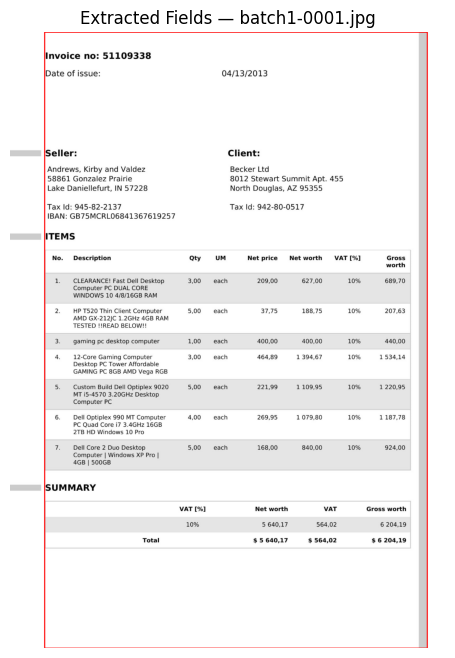

In [14]:
vis_final = invoice_color.copy()

def draw_box(img, item, color, label_name):
    x, y, w, h = item["box"]
    label = f"{label_name}: {item['value']}"
    cv2.rectangle(img, (x,y), (x+w,y+h), color, 2)
    cv2.putText(img, label, (x, y-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

if best_date:
    draw_box(vis_final, best_date, (255,0,0), "DATE")

if best_amount:
    draw_box(vis_final, best_amount, (0,255,0), "AMOUNT")

if best_tax:
    draw_box(vis_final, best_tax, (0,0,255), "TAX")

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(vis_final, cv2.COLOR_BGR2RGB))
plt.title(f"Extracted Fields — {INVOICE_FILE}")
plt.axis("off")
plt.show()